In [2]:
# Import packages
import os
import shutil
import pandas as pd
import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Load packages. Build dataset for the first time

In [2]:
# Read file with labels
xl_file = pd.ExcelFile('HP_WSI-CoordAnnotatedPatches.xlsx')

dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}

df = dfs['Sheet1']
df = df.loc[df['Presence'] != 0] # Delete uncertain cases

In [3]:
def rename_and_save_images(source_folder, destination_folder, data):
    ''' 
    Function to put the patient_id, window_id and label of each image
    within its name, in order to be able to move all images to the
    same folder and process them individually without having to look
    for its information somewhere else.
    data is a dataframe with the information of the images
    '''

    # Step 1: Create destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        print(f"Created folder: {destination_folder}")    
    
    # Step 2: Loop through each patient folder
    for patient in data['Pat_ID'].unique():
        pat_path = os.path.join(source_folder, patient+'_0') 
        # Check if the patient folder exists
        if not os.path.exists(pat_path):
            print(f"Patient folder does not exist: {pat_path}")
            continue
        
        # Step 3: Get list of all image files in the source folder
        image_files = [f for f in os.listdir(pat_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
        # Step 4: Rename and save each image to the destination folder
        for filename in image_files:
            # Define the new file name 
            window_id = filename.split('_')[0].split('.')[0].lstrip('0')
            if window_id == '':
                window_id = 0

            label = data.loc[data['Pat_ID'] == patient]            
            label = label.loc[label['Window_ID'] == int(window_id)]
            if label.empty:
                continue

            name = os.path.splitext(filename)[0].lstrip('0')
            if name == '':
                name = '0'
                
            new_filename = f"{patient}__{name}__{label.iloc[0]['Presence']}{os.path.splitext(filename)[1]}"
            
            # Define full path for source and destination
            src_path = os.path.join(pat_path, filename)
            dst_path = os.path.join(destination_folder, new_filename)
            
            # Copy and rename the file
            shutil.copy(src_path, dst_path)

In [174]:
# Calling function to process train set
source_folder = "Raw_Train_Set"
destination_folder = "Training_Set"
rename_and_save_images(source_folder, destination_folder, data=df)

Created folder: Training_Set


## Read new dataset

In [3]:
def read_images(folder):
    '''
    Function to retrieve the dataset. It returns a list with all the images retrieved.
    Each element of the list consists of a dictionary with two keys: 'img' and 'info'.
    The 'img' key contains the image itself.
    The 'info' key contains a list with information about the image -> [patient, window_id, label] All elements of the list are strings
    '''
    # Check if the folder exists
    if not os.path.exists(folder):
        print(f"Folder does not exist: {folder}")  

    # Read images
    images = []
    for img in os.listdir(folder):
        if img.endswith(('.png', '.jpg', '.jpeg')):
            temp_path = os.path.join(folder, img)

            temp_dict = {}  
            temp_dict['img'] = Image.open(temp_path).convert("RGB") # Image in RGB ready to be processed          
            temp_dict['info'] = os.path.splitext(img)[0].split('__') # List with the image information
            images.append(temp_dict)
    
    return images

In [4]:
# Calling function to read train set
folder = "Training_Set"
images = read_images(folder)

In [5]:
len(images)

2508

In [6]:
# 1 has the bacteria 
# -1 does not have the bacteria
images[31] 

{'img': <PIL.Image.Image image mode=RGB size=256x256>,
 'info': ['B22-102', '3838', '-1']}

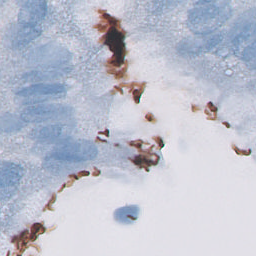

In [7]:
display(images[69]['img'])

## Color analysis

In [ ]:
def color_img(img_num):
    # Convert image from PIL to Opencv
    image = np.array(images[img_num]['img'].convert('RGB'))[:, :, ::-1].copy()
    
    # Split the channels (OpenCV loads images in BGR format)
    blue_channel, green_channel, red_channel = cv2.split(image)
    
    # Calculate the mean intensity for each color channel
    blue_mean = np.mean(blue_channel)
    green_mean = np.mean(green_channel)
    red_mean = np.mean(red_channel)   
    
    return blue_mean, green_mean, red_mean  

In [ ]:
# Example usage
negative = {'r': [], 'g': [], 'b': []} # -1
positive = {'r': [], 'g': [], 'b': []} # 1

for i in range(len(images)):  

    if images[i]['info'][2] == '1': 
        r,g,b = color_img(i)
        positive['r'].append(r)
        positive['g'].append(g)
        positive['b'].append(b)
    
    else:
        r,g,b = color_img(i)
        negative['r'].append(r)
        negative['g'].append(g)
        negative['b'].append(b)

In [ ]:
print('Positive class: ', np.mean(positive['r']), np.mean(positive['g']), np.mean(positive['b']))
print('Negative class: ', np.mean(negative['r']), np.mean(negative['g']), np.mean(negative['b']))

Positive class:  223.95335124812715 207.76578664910303 206.06294596423842
Negative class:  226.97679679812367 209.2815976179283 205.46347006586672


## Autoencoder

In [8]:
# Define transformations
# Resizing to 256x256 and converting to tensor with normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1] range
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1] range
])

# Custom dataset class
class PILImageDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]['img']
        if self.transform:
            img = self.transform(img)
        return img

# Create dataset and dataloader
dataset = PILImageDataset(images, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # Adjust batch size as needed

In [9]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 256x256 -> 128x128
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x128 -> 64x64
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(True)            
        )
        
        # Decoder
        self.decoder = nn.Sequential(            
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 64x64 -> 128x128
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),     # 128x128 -> 256x256
            nn.Sigmoid()  # Use sigmoid to scale output to (0, 1) for normalized RGB
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Example usage
model = ConvAutoencoder()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
)

In [11]:
len(dataloader)

79

In [13]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1

# Example training loop
for epoch in range(num_epochs):
    ii = 0
    for data in dataloader:  # Assuming `dataloader` provides (images) batches  
        ii+=1      
        img = data.to(device)
        
        # Forward pass
        output = model(img)
        loss = criterion(output, img)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'{ii}/{len(dataloader)} batches done!')
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

1/79 batches done!
2/79 batches done!
3/79 batches done!
4/79 batches done!
5/79 batches done!
6/79 batches done!
7/79 batches done!
8/79 batches done!
9/79 batches done!
10/79 batches done!
11/79 batches done!
12/79 batches done!
13/79 batches done!
14/79 batches done!
15/79 batches done!
16/79 batches done!
17/79 batches done!
18/79 batches done!
19/79 batches done!
20/79 batches done!
21/79 batches done!
22/79 batches done!
23/79 batches done!
24/79 batches done!
25/79 batches done!
26/79 batches done!
27/79 batches done!
28/79 batches done!
29/79 batches done!
30/79 batches done!
31/79 batches done!
32/79 batches done!
33/79 batches done!
34/79 batches done!
35/79 batches done!
36/79 batches done!
37/79 batches done!
38/79 batches done!
39/79 batches done!
40/79 batches done!
41/79 batches done!
42/79 batches done!
43/79 batches done!
44/79 batches done!
45/79 batches done!
46/79 batches done!
47/79 batches done!
48/79 batches done!
49/79 batches done!
50/79 batches done!
51/79 bat

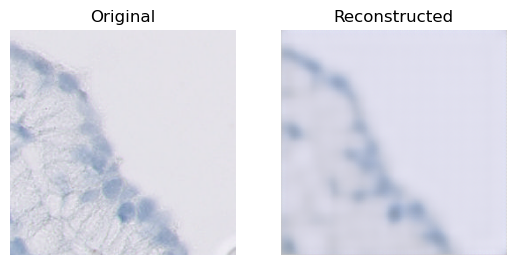

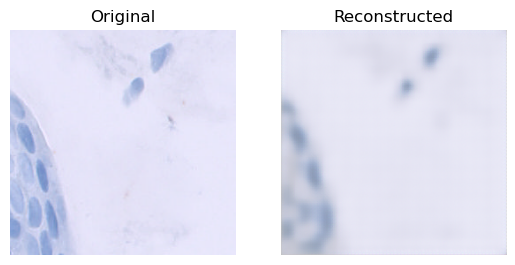

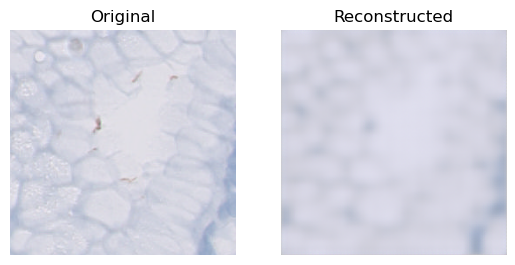

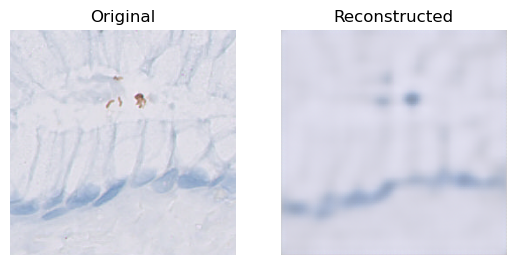

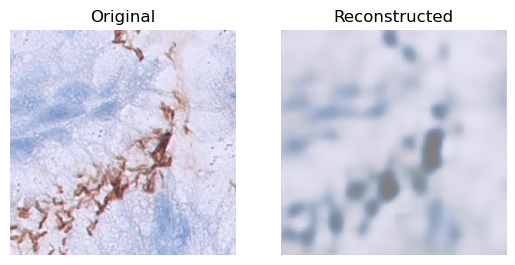

In [14]:
# Load the trained model (assuming model is already defined and loaded with weights)
# Uncomment the next line if you need to load model weights from a saved file
# model.load_state_dict(torch.load("path_to_model_weights.pth"))

# Set model to evaluation mode
model.eval()

# Move model to the same device as data (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to perform inference and display the input and reconstructed images
def infer_and_display(dataloader, model, num_images=5):
    with torch.no_grad():  # Disable gradient computation for inference
        for batch in dataloader:
            batch = batch.to(device)
            
            # Pass the batch through the autoencoder
            reconstructed = model(batch)
            
            # Move data back to CPU for visualization
            batch = batch.cpu()
            reconstructed = reconstructed.cpu()
            
            # Display a few input and output images
            for i in range(min(num_images, len(batch))):
                original_img = ToPILImage()(batch[i] * 0.5 + 0.5)  # Unnormalize [-1, 1] -> [0, 1]
                reconstructed_img = ToPILImage()(reconstructed[i] * 0.5 + 0.5)
                
                # Plot the original and reconstructed images side by side
                fig, axes = plt.subplots(1, 2)
                axes[0].imshow(np.asarray(original_img))
                axes[0].set_title("Original")
                axes[0].axis("off")

                axes[1].imshow(np.asarray(reconstructed_img))
                axes[1].set_title("Reconstructed")
                axes[1].axis("off")

                plt.show()
            
            break  # Only display one batch; remove this to go through all batches

# Perform inference and display results
infer_and_display(dataloader, model, num_images=5)